In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from GDST import GDST
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/home/scl2024/anaconda3/envs/GDST/lib/R'
os.environ['R_USER'] = '/home/scl2024/anaconda3/envs/GDST/lib/python3.12/site-packages/rpy2'
n_clusters = 5
dataset = '151671'

In [93]:
file_fold = '/home/scl2024/Data/1.DLPFC/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4110 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [94]:
from GDST import preprocess
preprocess(adata)
from GDST import construct_interaction
construct_interaction(adata)
from GDST import get_feature_with_diffusion
get_feature_with_diffusion(adata, tau=0.8, mix_ratio=0.2)
model = GDST(adata, epochs=1000, device=device)
adata = model.train()

开始训练ST数据


100%|██████████| 1000/1000 [00:39<00:00, 25.31it/s]

结束


In [95]:
radius = 50
tool = 'mclust' # mclust, leiden, and louvain
from GDST import clustering
if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [96]:
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [97]:
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
print('Dataset:', dataset)
print('ARI:', ARI)

Dataset: 151671
ARI: 0.8385729917591586


In [98]:
import torch

print("X type:", type(adata.X))
print("obs['domain'] type:", type(adata.obs['domain'].values[0]))
print("obsm['emb'] type:", type(adata.obsm['emb']) if 'emb' in adata.obsm else "not present")



X type: <class 'scipy.sparse._csr.csr_matrix'>
obs['domain'] type: <class 'str'>
obsm['emb'] type: <class 'numpy.ndarray'>


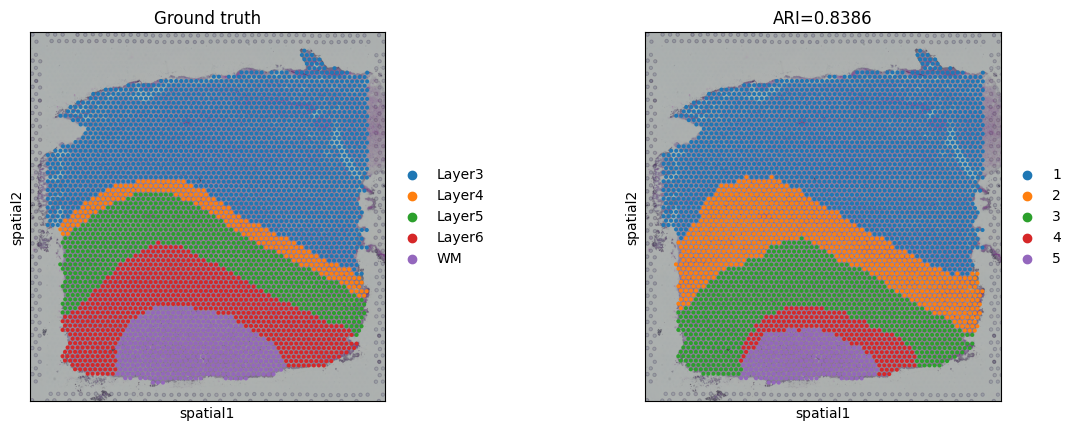

In [99]:
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],spot_size=110,
              show=True)

<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

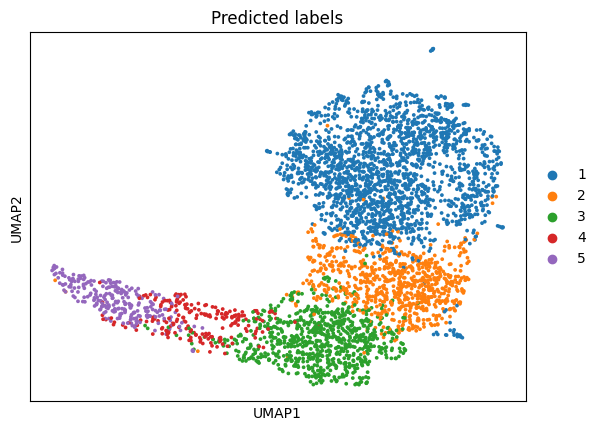

In [100]:
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)